## Sztuczne sieci neuronowe - laboratorium 14
### Miniprojekt

#### 1. Wybór danych

In [8]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np


## Wybrałem zbiór danych, z którego korzystałem w trakcie projektu z SSN. Plik dice_letters.csv zawiera dane z dwóch źródeł – dice_ext.csv i emnist_letters.csv. Są to emnistowe obrazki, które są używane do klasyfikacji binarnej, gdzie 0 oznacza kostki, a 1 oznacza litery alfabetu.

dice_letters = pd.read_csv('dice_letters.csv', header=None)
X = dice_letters.iloc[:, 1:].values.astype(np.uint8)
y = dice_letters.iloc[:, 0].values.astype(np.int64)

#### 2. Krótka analiza danych

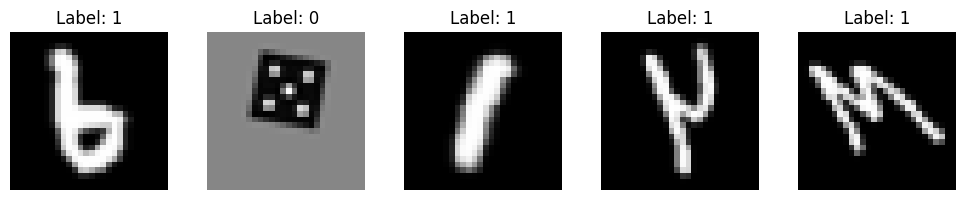

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194800 entries, 0 to 194799
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 1.1 GB
Rozkład klas:
0
1    124800
0     70000
Name: count, dtype: int64


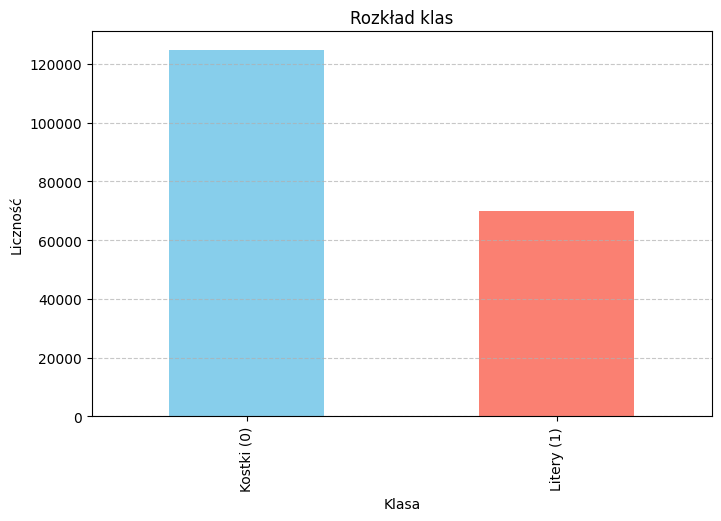


Udział procentowy:
0 (Kostki): 35.93%
1 (Litery): 64.07%


In [9]:
from matplotlib import pyplot as plt


def plot_samples(data, labels, num_samples=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


plot_samples(X, y, num_samples=5)

dice_letters.info()

dice_letters.describe()

label_counts = dice_letters.iloc[:, 0].value_counts()
print("Rozkład klas:")
print(label_counts)

plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Rozkład klas')
plt.xlabel('Klasa')
plt.ylabel('Liczność')
plt.xticks([0, 1], ['Kostki (0)', 'Litery (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

total = len(dice_letters)
percentages = (label_counts / total) * 100
print(f"\nUdział procentowy:\n0 (Kostki): {percentages[0]:.2f}%\n1 (Litery): {percentages[1]:.2f}%")


#### 3. Zastosowanie augmentacji

In [10]:
from torchvision import transforms


train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

class DiceLetterDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx].reshape(28, 28)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0
        label = int(self.y[idx])
        return img, label

#### 4. Wytrenowanie dwóch modeli

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train_dataset = DiceLetterDataset(X_train, y_train, transform=train_transform)
test_dataset = DiceLetterDataset(X_test, y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

import torch.nn as nn
import torch.optim as optim

## Pierwszy model - sieć konwolucyjna
class DiceLetter(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 7 * 7, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu', writer=None):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_acc = correct / total
        train_accs.append(train_acc)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        test_acc = correct / total
        test_accs.append(test_acc)

        if writer:
            writer.add_scalar('Train/Accuracy', train_acc, epoch)
            writer.add_scalar('Test/Accuracy', test_acc, epoch)
        print(f"Epoch {epoch + 1}/{epochs} - Train acc: {train_acc:.4f} - Test acc: {test_acc:.4f}")

    return train_accs, test_accs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = DiceLetter()
train_accs, test_accs = train_model(cnn_model, train_loader, test_loader, epochs=10, device=device)

## Drugi model - regresja logistyczna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train_flat = X_train.reshape(-1, 28 * 28)
X_test_flat = X_test.reshape(-1, 28 * 28)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_flat, y_train)
y_pred = logreg.predict(X_test_flat)
logreg_acc = accuracy_score(y_test, y_pred)
print(f"Logistic Regression test accuracy: {logreg_acc:.4f}")


Epoch 1/10 - Train acc: 0.9956 - Test acc: 0.9996
Epoch 2/10 - Train acc: 0.9982 - Test acc: 0.9990
Epoch 3/10 - Train acc: 0.9988 - Test acc: 0.9996
Epoch 4/10 - Train acc: 0.9989 - Test acc: 0.9998
Epoch 5/10 - Train acc: 0.9990 - Test acc: 0.9998
Epoch 6/10 - Train acc: 0.9992 - Test acc: 0.9997
Epoch 7/10 - Train acc: 0.9992 - Test acc: 0.9994
Epoch 8/10 - Train acc: 0.9992 - Test acc: 0.9998
Epoch 9/10 - Train acc: 0.9992 - Test acc: 0.9998
Epoch 10/10 - Train acc: 0.9993 - Test acc: 0.9998
Logistic Regression test accuracy: 0.9975


#### 5. Porównanie wyników

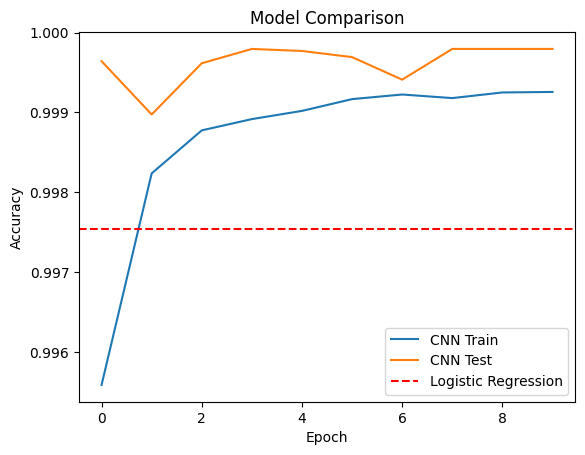

In [12]:
plt.plot(train_accs, label='CNN Train')
plt.plot(test_accs, label='CNN Test')
plt.axhline(logreg_acc, color='r', linestyle='--', label='Logistic Regression')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.legend()
plt.show()

#### 6. Przedstawienie wyników przy pomocy Tensorboard

In [13]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/dice_letter_experiment')
_ = train_model(DiceLetter(), train_loader, test_loader, epochs=10, device=device, writer=writer)
writer.close()

Epoch 1/10 - Train acc: 0.9951 - Test acc: 0.9993
Epoch 2/10 - Train acc: 0.9983 - Test acc: 0.9993
Epoch 3/10 - Train acc: 0.9987 - Test acc: 0.9996
Epoch 4/10 - Train acc: 0.9988 - Test acc: 0.9996
Epoch 5/10 - Train acc: 0.9990 - Test acc: 0.9995
Epoch 6/10 - Train acc: 0.9991 - Test acc: 0.9998
Epoch 7/10 - Train acc: 0.9992 - Test acc: 0.9998
Epoch 8/10 - Train acc: 0.9994 - Test acc: 0.9997
Epoch 9/10 - Train acc: 0.9993 - Test acc: 0.9997
Epoch 10/10 - Train acc: 0.9994 - Test acc: 0.9998


#### Wnioski
Model CNN przewyższa bazowy model regresji logistycznej, co pokazuje przewagę architektury konwolucyjnej w zadaniach związanych z danymi obrazowymi. Augmentacja danych oraz wizualizacja wyników w TensorBoard dodatkowo wspierają solidny rozwój i analizę modeli.